In [89]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.regularizers import l2, l1

Constant

In [52]:
%store -r DATA_LOCATION 
%store -r GENRES
%store -r data_train_location
%store -r data_test_location

Functions:

In [8]:
max_pad_len = 1320
def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print(e)
        print("Error encountered while parsing file: ", file_name)
        return None 
       
    return mfccs

def extract_features2(file_name):

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
    except Exception as e:
        print(e)
        print("Error encountered while parsing file: ", file_name)
        return None 
       
    return mfccs.shape[1]

def fit_model(model, X, Y, x_test, y_test, epochs, batch_size, file_name):
    checkpoint = ModelCheckpoint("saved_models/" + file_name, verbose=1, save_best_only=True)
    
    start = datetime.now()
    history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[checkpoint], 
                        verbose=1)
    
    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    return history


def model_plot_validation(history):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))
    
    ax0.set_title('Accuracy')
    ax0.plot(history.history['accuracy'])
    ax0.plot(history.history['val_accuracy'])
    ax0.legend(['train','validation'])

    ax1.set_title('Loss')
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train','validation'])
    

def add_noise(data):
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise


def shift(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    audio_shift = librosa.effects.pitch_shift(data.astype('float64'), sample_rate, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return audio_shift


def stretch(data):
    y_speed = data.copy()
    tmp = librosa.effects.time_stretch(data, 1.7)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0 
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed    
    
def get_augmented_data(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        librosa_audio_shift = shift(audio, sample_rate)
        librosa_audio_with_noise = add_noise(audio)
        librosa_audio_stretch = stretch(audio)
    except Exception as e:
        print(e)
        print("Error encountered while parsing file: ", file_name)
        return None 
       
    return ([audio, librosa_audio_shift, librosa_audio_with_noise, librosa_audio_stretch], sample_rate)    


def extract_features_from_audio(data, sample_rate):
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    return np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    

def model1(num_rows, num_columns, num_channels, activation, kernel_size, pool_size, dropout):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=kernel_size, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

# 6. CNN Model

We will modify our model to be a Convolutional Neural Network (CNN).

We will begin with a model, consisting of five layers:
1. input layer (convulation + max pooling): 16 units, Relu activation function and 0.2% of dropout.
2. convulation + max pooling layer: 32 units, Relu activation function and 0.2% of dropout.
3. convulation + max pooling layer: 64 units, Relu activation function and 0.2% of dropout. 
4. convulation + max pooling layer: 128 units, Relu activation function and 0.2% of dropout. 
5. output layer 


Before training our model we need to prepare the data again, as the input of our model must be (40 x max_num_frames x 1). First let's check which is the maximum number of frames we have to consider:

In [23]:
features = []
for genre in GENRES:
    for i in range(100):
        file_name = os.path.join(os.path.abspath(DATA_LOCATION), genre + '/', genre + '.' + str(i).rjust(5, '0') + '.au')
        data = extract_features2(file_name)
        
        features.append([data, genre])

featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  1000  files


In [24]:
featuresdf.feature.max()

1320

The max number of frames is 1320.

Now we can extract the features from each sample:

In [25]:
features = []
for genre in GENRES:
    for i in range(100):
        file_name = os.path.join(os.path.abspath(DATA_LOCATION), genre + '/', genre + '.' + str(i).rjust(5, '0') + '.au')
        data = extract_features(file_name)
        
        features.append([data, genre])

featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  1000  files


Let's check the result is correct:

In [26]:
featuresdf.head()

,feature,class_label
0,"[[-211.48465, -208.94481, -193.90889, -174.618...",blues
1,"[[-312.9025, -223.67754, -156.06529, -148.9106...",blues
2,"[[-60.05452, -71.44897, -96.38281, -108.587616...",blues
3,"[[-187.64453, -196.83621, -213.41223, -220.421...",blues
4,"[[-251.46812, -180.03836, -155.01845, -173.169...",blues


In [27]:
len(featuresdf.iloc[0, 0:][0]), len(featuresdf.iloc[0, 0:][0][0])

(40, 1320)

Each row (sample) has 40 MCCs and 1320 frames.

In [28]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

In [29]:
len(X[0]), len(X[0][0]), X.shape

(40, 1320, (1000, 40, 1320))

Now we may split data into train and test:

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [31]:
num_rows = 40 #coefficients
num_columns = 1320 #frames
num_channels = 1  #mono-channel

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

Let's define the first CNN model:

In [32]:
num_labels = yy.shape[1]

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(num_labels, activation='softmax')) 

In [33]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [34]:
history = fit_model(model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv1.hdf5')

Epoch 1/100
25/25 [==============================] - 121s 5s/step - loss: 24.5405 - accuracy: 0.0997 - val_loss: 2.1802 - val_accuracy: 0.1850

Epoch 00001: val_loss improved from inf to 2.18023, saving model to saved_models\conv1.hdf5
Epoch 2/100
25/25 [==============================] - 95s 4s/step - loss: 2.0054 - accuracy: 0.2707 - val_loss: 1.9070 - val_accuracy: 0.3400

Epoch 00002: val_loss improved from 2.18023 to 1.90703, saving model to saved_models\conv1.hdf5
Epoch 3/100
25/25 [==============================] - 100s 4s/step - loss: 1.7333 - accuracy: 0.3829 - val_loss: 1.7299 - val_accuracy: 0.3600

Epoch 00003: val_loss improved from 1.90703 to 1.72994, saving model to saved_models\conv1.hdf5
Epoch 4/100
25/25 [==============================] - 111s 4s/step - loss: 1.4488 - accuracy: 0.4668 - val_loss: 1.6606 - val_accuracy: 0.4050

Epoch 00004: val_loss improved from 1.72994 to 1.66065, saving model to saved_models\conv1.hdf5
Epoch 5/100
25/25 [=============================

25/25 [==============================] - 29s 1s/step - loss: 0.0798 - accuracy: 0.9777 - val_loss: 3.0893 - val_accuracy: 0.4500

Epoch 00083: val_loss did not improve from 1.52013
Epoch 84/100
25/25 [==============================] - 29s 1s/step - loss: 0.0936 - accuracy: 0.9727 - val_loss: 3.1236 - val_accuracy: 0.4900

Epoch 00084: val_loss did not improve from 1.52013
Epoch 85/100
25/25 [==============================] - 29s 1s/step - loss: 0.0794 - accuracy: 0.9733 - val_loss: 2.8526 - val_accuracy: 0.4950

Epoch 00085: val_loss did not improve from 1.52013
Epoch 86/100
25/25 [==============================] - 30s 1s/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 2.8638 - val_accuracy: 0.5050

Epoch 00086: val_loss did not improve from 1.52013
Epoch 87/100
25/25 [==============================] - 29s 1s/step - loss: 0.0495 - accuracy: 0.9791 - val_loss: 3.1177 - val_accuracy: 0.4850

Epoch 00087: val_loss did not improve from 1.52013
Epoch 88/100
25/25 [=======================

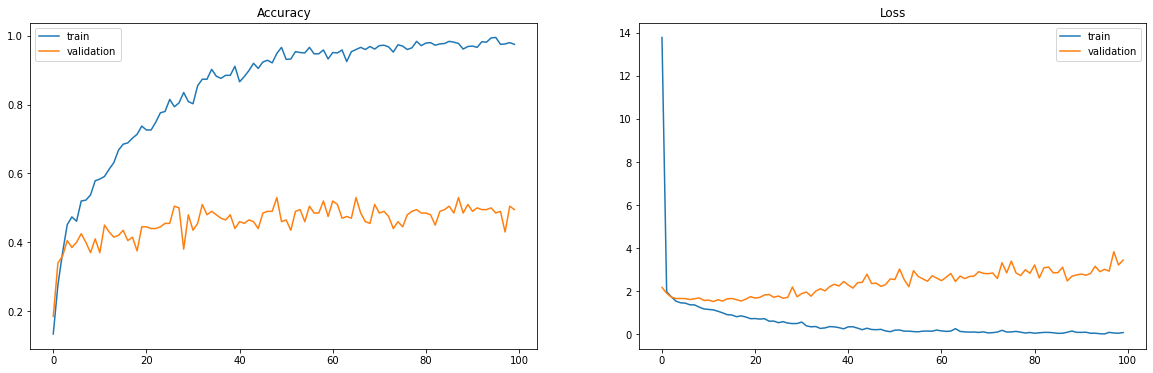

In [35]:
model_plot_validation(history)

In [45]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])
print("Training Loss: ", score[0])

Training Accuracy:  0.9837499856948853
Training Loss:  0.0567304901778698
Testing Accuracy:  0.4950000047683716
Training Loss:  3.4469025135040283


With this new model we still have overfiting and this is even worst that our last MLP model.

**Model modifications:**

Now let's try to do some modifications to see wether we can improve the model performance.

##### Dropout 

We will see if there is any difference by changing the dropout percentage. We will try:
- 0.05
- 0.5
- 0.7

In [109]:
model_1 = model1(num_rows, num_columns, num_channels, 'relu', kernel_size = 2, pool_size = 2, dropout= 0.05)
model_2 = model1(num_rows, num_columns, num_channels, 'relu', kernel_size = 2, pool_size = 2, dropout= 0.5)
model_3 = model1(num_rows, num_columns, num_channels, 'relu', kernel_size = 2, pool_size = 2, dropout= 0.7)

In [110]:
model_1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [111]:
history1 = fit_model(model_1, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv1.hdf5')
history2 = fit_model(model_2, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv2.hdf5')
history3 = fit_model(model_3, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv3.hdf5')

Epoch 1/100
25/25 [==============================] - 170s 6s/step - loss: 11.4380 - accuracy: 0.1380 - val_loss: 2.1778 - val_accuracy: 0.2050

Epoch 00001: val_loss improved from inf to 2.17784, saving model to saved_models\conv1.hdf5
Epoch 2/100
25/25 [==============================] - 37s 1s/step - loss: 1.8715 - accuracy: 0.3254 - val_loss: 1.6448 - val_accuracy: 0.4050

Epoch 00002: val_loss improved from 2.17784 to 1.64485, saving model to saved_models\conv1.hdf5
Epoch 3/100
25/25 [==============================] - 38s 2s/step - loss: 1.4644 - accuracy: 0.4436 - val_loss: 1.5675 - val_accuracy: 0.4400

Epoch 00003: val_loss improved from 1.64485 to 1.56749, saving model to saved_models\conv1.hdf5
Epoch 4/100
25/25 [==============================] - 38s 2s/step - loss: 1.3862 - accuracy: 0.5139 - val_loss: 1.4749 - val_accuracy: 0.4700

Epoch 00004: val_loss improved from 1.56749 to 1.47490, saving model to saved_models\conv1.hdf5
Epoch 5/100
25/25 [==============================]


Epoch 00041: val_loss did not improve from 1.37576
Epoch 42/100
25/25 [==============================] - 34s 1s/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 3.0442 - val_accuracy: 0.5050

Epoch 00042: val_loss did not improve from 1.37576
Epoch 43/100
25/25 [==============================] - 34s 1s/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 2.9291 - val_accuracy: 0.5200

Epoch 00043: val_loss did not improve from 1.37576
Epoch 44/100
25/25 [==============================] - 35s 1s/step - loss: 0.0114 - accuracy: 0.9993 - val_loss: 3.2156 - val_accuracy: 0.5400

Epoch 00044: val_loss did not improve from 1.37576
Epoch 45/100
25/25 [==============================] - 35s 1s/step - loss: 0.0120 - accuracy: 0.9934 - val_loss: 3.3275 - val_accuracy: 0.5200

Epoch 00045: val_loss did not improve from 1.37576
Epoch 46/100
25/25 [==============================] - 34s 1s/step - loss: 0.0313 - accuracy: 0.9899 - val_loss: 3.4360 - val_accuracy: 0.5200

Epoch 00046: val_loss did not

25/25 [==============================] - 109s 4s/step - loss: 0.0054 - accuracy: 0.9993 - val_loss: 3.6656 - val_accuracy: 0.4800

Epoch 00084: val_loss did not improve from 1.37576
Epoch 85/100
25/25 [==============================] - 108s 4s/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 3.5844 - val_accuracy: 0.4900

Epoch 00085: val_loss did not improve from 1.37576
Epoch 86/100
25/25 [==============================] - 109s 4s/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 3.4322 - val_accuracy: 0.4900

Epoch 00086: val_loss did not improve from 1.37576
Epoch 87/100
25/25 [==============================] - 110s 4s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.4972 - val_accuracy: 0.4850

Epoch 00087: val_loss did not improve from 1.37576
Epoch 88/100
25/25 [==============================] - 112s 4s/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 3.5002 - val_accuracy: 0.4750

Epoch 00088: val_loss did not improve from 1.37576
Epoch 89/100
25/25 [==================

25/25 [==============================] - 34s 1s/step - loss: 1.1941 - accuracy: 0.5520 - val_loss: 2.0204 - val_accuracy: 0.2600

Epoch 00062: val_loss did not improve from 1.89798
Epoch 63/100
25/25 [==============================] - 36s 1s/step - loss: 1.2549 - accuracy: 0.5218 - val_loss: 2.0144 - val_accuracy: 0.2500

Epoch 00063: val_loss did not improve from 1.89798
Epoch 64/100
25/25 [==============================] - 40s 2s/step - loss: 1.2806 - accuracy: 0.5205 - val_loss: 2.0375 - val_accuracy: 0.2250

Epoch 00064: val_loss did not improve from 1.89798
Epoch 65/100
25/25 [==============================] - 46s 2s/step - loss: 1.2142 - accuracy: 0.5335 - val_loss: 2.0802 - val_accuracy: 0.2250

Epoch 00065: val_loss did not improve from 1.89798
Epoch 66/100
25/25 [==============================] - 42s 2s/step - loss: 1.1541 - accuracy: 0.5433 - val_loss: 1.9937 - val_accuracy: 0.2550

Epoch 00066: val_loss did not improve from 1.89798
Epoch 67/100
25/25 [=======================

25/25 [==============================] - 33s 1s/step - loss: 2.2176 - accuracy: 0.1777 - val_loss: 2.3097 - val_accuracy: 0.0650

Epoch 00044: val_loss did not improve from 2.28413
Epoch 45/100
25/25 [==============================] - 34s 1s/step - loss: 2.2441 - accuracy: 0.1535 - val_loss: 2.3103 - val_accuracy: 0.0650

Epoch 00045: val_loss did not improve from 2.28413
Epoch 46/100
25/25 [==============================] - 34s 1s/step - loss: 2.2169 - accuracy: 0.1540 - val_loss: 2.3105 - val_accuracy: 0.0650

Epoch 00046: val_loss did not improve from 2.28413
Epoch 47/100
25/25 [==============================] - 34s 1s/step - loss: 2.1902 - accuracy: 0.1769 - val_loss: 2.3109 - val_accuracy: 0.0650

Epoch 00047: val_loss did not improve from 2.28413
Epoch 48/100
25/25 [==============================] - 34s 1s/step - loss: 2.1888 - accuracy: 0.1983 - val_loss: 2.3113 - val_accuracy: 0.0650

Epoch 00048: val_loss did not improve from 2.28413
Epoch 49/100
25/25 [=======================

25/25 [==============================] - 35s 1s/step - loss: 2.0699 - accuracy: 0.2358 - val_loss: 2.2954 - val_accuracy: 0.0650

Epoch 00086: val_loss did not improve from 2.26967
Epoch 87/100
25/25 [==============================] - 36s 1s/step - loss: 2.0553 - accuracy: 0.2366 - val_loss: 2.2941 - val_accuracy: 0.0650

Epoch 00087: val_loss did not improve from 2.26967
Epoch 88/100
25/25 [==============================] - 34s 1s/step - loss: 2.0065 - accuracy: 0.2426 - val_loss: 2.2668 - val_accuracy: 0.0750

Epoch 00088: val_loss improved from 2.26967 to 2.26676, saving model to saved_models\conv3.hdf5
Epoch 89/100
25/25 [==============================] - 34s 1s/step - loss: 2.0788 - accuracy: 0.1929 - val_loss: 2.2586 - val_accuracy: 0.0750

Epoch 00089: val_loss improved from 2.26676 to 2.25863, saving model to saved_models\conv3.hdf5
Epoch 90/100
25/25 [==============================] - 34s 1s/step - loss: 2.0653 - accuracy: 0.2186 - val_loss: 2.2834 - val_accuracy: 0.0650

Epoc

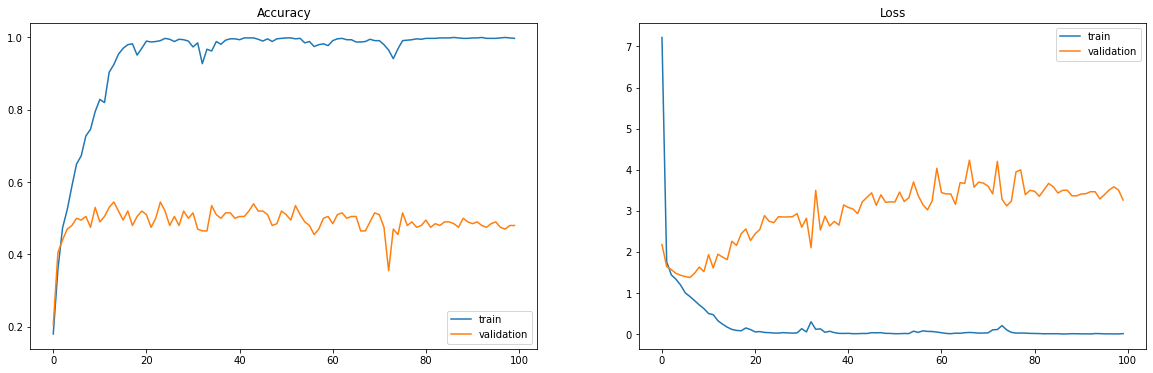

In [112]:
model_plot_validation(history1)

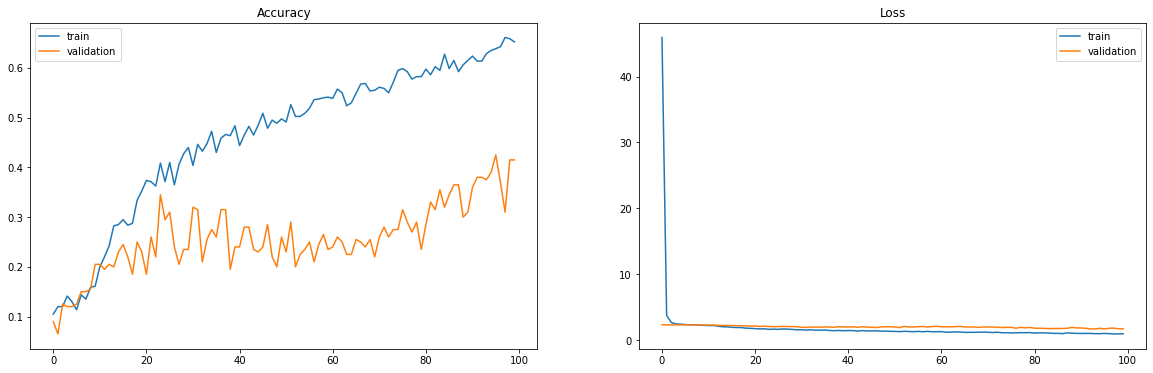

In [113]:
model_plot_validation(history2)

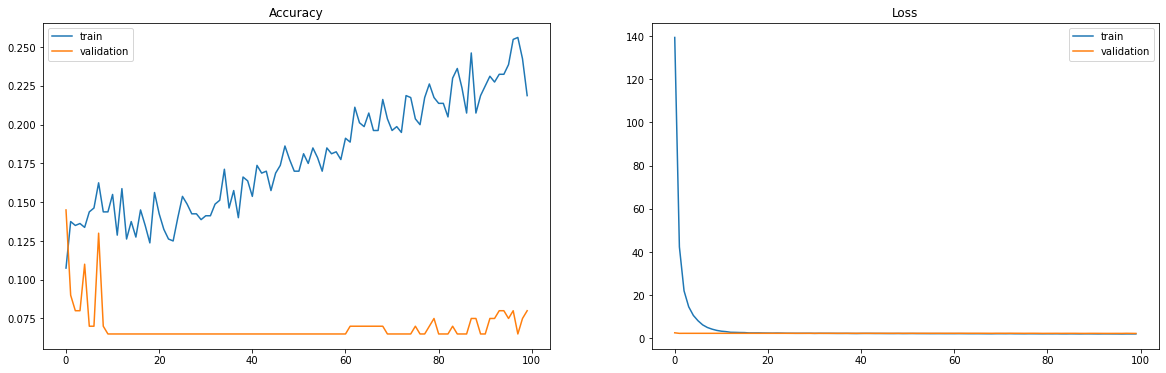

In [114]:
model_plot_validation(history3)

In [115]:
print("Training Accuracy model 1: ", model_1.evaluate(x_train, y_train, verbose=0)[1])
print("Testing Accuracy model 1: ", model_1.evaluate(x_test, y_test, verbose=0)[1])

print("Training Accuracy model 2: ", model_2.evaluate(x_train, y_train, verbose=0)[1])
print("Testing Accuracy model 2: ", model_2.evaluate(x_test, y_test, verbose=0)[1])

print("Training Accuracy model 3: ", model_3.evaluate(x_train, y_train, verbose=0)[1])
print("Testing Accuracy model 3: ", model_3.evaluate(x_test, y_test, verbose=0)[1])

Training Accuracy model 1:  0.9987499713897705
Testing Accuracy model 1:  0.47999998927116394
Training Accuracy model 2:  0.5287500023841858
Testing Accuracy model 2:  0.41499999165534973
Training Accuracy model 3:  0.13500000536441803
Testing Accuracy model 3:  0.07999999821186066


It seems no one of these modifications has improved the model. However, taking a look at the graphics we can see that a dropout of 0.2 could have higher accuracy and lower loss if we increase the number of epochs.

So, let's try _model_2_ but with 200 epochs.

In [116]:
model_2 = model1(num_rows, num_columns, num_channels, 'relu', kernel_size = 2, pool_size = 2, dropout= 0.5)
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [117]:
history4 = fit_model(model_2, x_train, y_train, x_test, y_test, epochs=200, batch_size=32, file_name='conv4.hdf5')

Epoch 1/200
25/25 [==============================] - 38s 1s/step - loss: 73.6658 - accuracy: 0.1217 - val_loss: 2.2449 - val_accuracy: 0.1300

Epoch 00001: val_loss improved from inf to 2.24493, saving model to saved_models\conv4.hdf5
Epoch 2/200
25/25 [==============================] - 35s 1s/step - loss: 6.2411 - accuracy: 0.1504 - val_loss: 2.2738 - val_accuracy: 0.1550

Epoch 00002: val_loss did not improve from 2.24493
Epoch 3/200
25/25 [==============================] - 35s 1s/step - loss: 3.6392 - accuracy: 0.1446 - val_loss: 2.2919 - val_accuracy: 0.1300

Epoch 00003: val_loss did not improve from 2.24493
Epoch 4/200
25/25 [==============================] - 35s 1s/step - loss: 2.7560 - accuracy: 0.1812 - val_loss: 2.2794 - val_accuracy: 0.2250

Epoch 00004: val_loss did not improve from 2.24493
Epoch 5/200
25/25 [==============================] - 34s 1s/step - loss: 2.4376 - accuracy: 0.2136 - val_loss: 2.2774 - val_accuracy: 0.2150

Epoch 00005: val_loss did not improve from 2

25/25 [==============================] - 35s 1s/step - loss: 1.1367 - accuracy: 0.5664 - val_loss: 1.7624 - val_accuracy: 0.3200

Epoch 00078: val_loss did not improve from 1.68803
Epoch 79/200
25/25 [==============================] - 35s 1s/step - loss: 1.0825 - accuracy: 0.6190 - val_loss: 1.7418 - val_accuracy: 0.3300

Epoch 00079: val_loss did not improve from 1.68803
Epoch 80/200
25/25 [==============================] - 35s 1s/step - loss: 1.1337 - accuracy: 0.5943 - val_loss: 1.7266 - val_accuracy: 0.3500

Epoch 00080: val_loss did not improve from 1.68803
Epoch 81/200
25/25 [==============================] - 34s 1s/step - loss: 1.0620 - accuracy: 0.6086 - val_loss: 1.6789 - val_accuracy: 0.3600

Epoch 00081: val_loss improved from 1.68803 to 1.67887, saving model to saved_models\conv4.hdf5
Epoch 82/200
25/25 [==============================] - 34s 1s/step - loss: 1.1916 - accuracy: 0.5736 - val_loss: 1.6929 - val_accuracy: 0.3600

Epoch 00082: val_loss did not improve from 1.6788

25/25 [==============================] - 35s 1s/step - loss: 0.6693 - accuracy: 0.7341 - val_loss: 1.4144 - val_accuracy: 0.4950

Epoch 00117: val_loss did not improve from 1.41362
Epoch 118/200
25/25 [==============================] - 35s 1s/step - loss: 0.7566 - accuracy: 0.7281 - val_loss: 1.3874 - val_accuracy: 0.4800

Epoch 00118: val_loss improved from 1.41362 to 1.38744, saving model to saved_models\conv4.hdf5
Epoch 119/200
25/25 [==============================] - 33s 1s/step - loss: 0.7611 - accuracy: 0.7248 - val_loss: 1.4592 - val_accuracy: 0.4700

Epoch 00119: val_loss did not improve from 1.38744
Epoch 120/200
25/25 [==============================] - 35s 1s/step - loss: 0.7276 - accuracy: 0.7396 - val_loss: 1.4445 - val_accuracy: 0.5000

Epoch 00120: val_loss did not improve from 1.38744
Epoch 121/200
25/25 [==============================] - 35s 1s/step - loss: 0.7513 - accuracy: 0.7362 - val_loss: 1.4171 - val_accuracy: 0.4550

Epoch 00121: val_loss did not improve from 1.

25/25 [==============================] - 35s 1s/step - loss: 0.3261 - accuracy: 0.8926 - val_loss: 1.3942 - val_accuracy: 0.5600

Epoch 00199: val_loss did not improve from 1.26396
Epoch 200/200
25/25 [==============================] - 35s 1s/step - loss: 0.3493 - accuracy: 0.8867 - val_loss: 1.3549 - val_accuracy: 0.5400

Epoch 00200: val_loss did not improve from 1.26396
Training completed in time:  1:56:46.346571


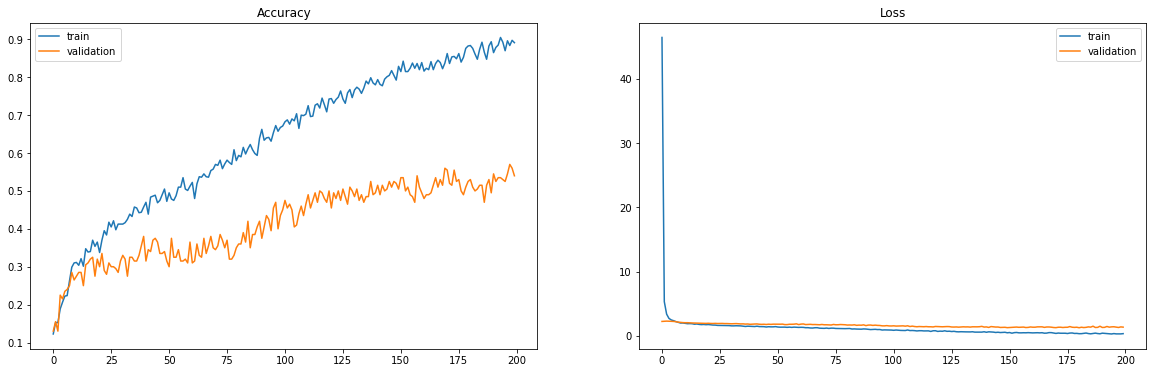

In [118]:
model_plot_validation(history4)

In [119]:
print("Training Accuracy model 4: ", model_2.evaluate(x_train, y_train, verbose=0)[1])
print("Testing Accuracy model 4: ", model_2.evaluate(x_test, y_test, verbose=0)[1])

print("Training Loss model 4: ", model_2.evaluate(x_train, y_train, verbose=0)[0])
print("Testing Loss model 4: ", model_2.evaluate(x_test, y_test, verbose=0)[0])

Training Accuracy model 4:  0.9125000238418579
Testing Accuracy model 4:  0.5400000214576721
Training Loss model 4:  0.36967822909355164
Testing Loss model 4:  1.354927659034729


Clearly, the test accuracy is better than before (49%).

##### Remove layers 

Another modification could be remove or adding new layers to the model, so let's remove one of the layers:

In [120]:
model_5 = Sequential()
model_5.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_5.add(MaxPooling2D(pool_size=2))
model_5.add(Dropout(0.2))

model_5.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_5.add(MaxPooling2D(pool_size=2))
model_5.add(Dropout(0.2))

model_5.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_5.add(MaxPooling2D(pool_size=2))
model_5.add(Dropout(0.2))

model_5.add(Flatten())
model_5.add(Dense(num_labels, activation='softmax')) 

In [121]:
model_5.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [122]:
history5 = fit_model(model_5, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv5.hdf5')

Epoch 1/100
25/25 [==============================] - 46s 1s/step - loss: 61.2933 - accuracy: 0.1524 - val_loss: 2.2688 - val_accuracy: 0.0950

Epoch 00001: val_loss improved from inf to 2.26883, saving model to saved_models\conv5.hdf5
Epoch 2/100
25/25 [==============================] - 33s 1s/step - loss: 2.3466 - accuracy: 0.2725 - val_loss: 2.2926 - val_accuracy: 0.1150

Epoch 00002: val_loss did not improve from 2.26883
Epoch 3/100
25/25 [==============================] - 35s 1s/step - loss: 2.0322 - accuracy: 0.2513 - val_loss: 1.9841 - val_accuracy: 0.2850

Epoch 00003: val_loss improved from 2.26883 to 1.98413, saving model to saved_models\conv5.hdf5
Epoch 4/100
25/25 [==============================] - 34s 1s/step - loss: 1.6551 - accuracy: 0.4481 - val_loss: 1.8228 - val_accuracy: 0.2800

Epoch 00004: val_loss improved from 1.98413 to 1.82276, saving model to saved_models\conv5.hdf5
Epoch 5/100
25/25 [==============================] - 33s 1s/step - loss: 1.4457 - accuracy: 0.48

25/25 [==============================] - 33s 1s/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 3.9719 - val_accuracy: 0.4250

Epoch 00084: val_loss did not improve from 1.65530
Epoch 85/100
25/25 [==============================] - 33s 1s/step - loss: 0.0102 - accuracy: 0.9967 - val_loss: 4.1451 - val_accuracy: 0.4100

Epoch 00085: val_loss did not improve from 1.65530
Epoch 86/100
25/25 [==============================] - 33s 1s/step - loss: 0.0221 - accuracy: 0.9938 - val_loss: 4.2879 - val_accuracy: 0.4000

Epoch 00086: val_loss did not improve from 1.65530
Epoch 87/100
25/25 [==============================] - 33s 1s/step - loss: 0.0130 - accuracy: 0.9958 - val_loss: 4.0994 - val_accuracy: 0.4100

Epoch 00087: val_loss did not improve from 1.65530
Epoch 88/100
25/25 [==============================] - 34s 1s/step - loss: 0.0076 - accuracy: 0.9972 - val_loss: 3.8050 - val_accuracy: 0.4250

Epoch 00088: val_loss did not improve from 1.65530
Epoch 89/100
25/25 [=======================

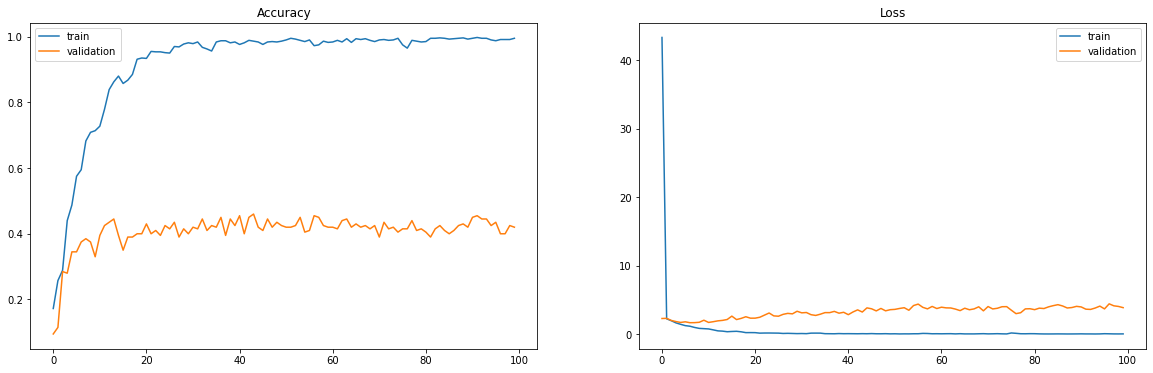

In [123]:
model_plot_validation(history5)

In [124]:
print("Training Accuracy model 5: ", model_5.evaluate(x_train, y_train, verbose=0)[1])
print("Testing Accuracy model 5: ", model_5.evaluate(x_test, y_test, verbose=0)[1])

print("Training Loss model 5: ", model_5.evaluate(x_train, y_train, verbose=0)[0])
print("Testing Loss model 5: ", model_5.evaluate(x_test, y_test, verbose=0)[0])

Training Accuracy model 5:  0.9987499713897705
Testing Accuracy model 5:  0.41999998688697815
Training Loss model 5:  0.003495293203741312
Testing Loss model 5:  3.851966619491577


There is no improvement for the test data.

##### Change regularizer 

The following modification will be to change the regularizer. So we will replace the doprout by L2 or L1 regularizers.

###### L2 

In [125]:
model_6 = Sequential()
model_6.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu', kernel_regularizer=l2(0.001)))
model_6.add(MaxPooling2D(pool_size=2))

model_6.add(Conv2D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001)))
model_6.add(MaxPooling2D(pool_size=2))

model_6.add(Conv2D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001)))
model_6.add(MaxPooling2D(pool_size=2))

model_6.add(Conv2D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001)))
model_6.add(MaxPooling2D(pool_size=2))

model_6.add(Flatten())
model_6.add(Dense(num_labels, activation='softmax')) 

In [126]:
model_6.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [127]:
history6 = fit_model(model_6, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv6.hdf5')

Epoch 1/100
25/25 [==============================] - 33s 1s/step - loss: 9.8284 - accuracy: 0.1797 - val_loss: 1.9342 - val_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 1.93424, saving model to saved_models\conv6.hdf5
Epoch 2/100
25/25 [==============================] - 30s 1s/step - loss: 1.6254 - accuracy: 0.4752 - val_loss: 1.7582 - val_accuracy: 0.4200

Epoch 00002: val_loss improved from 1.93424 to 1.75822, saving model to saved_models\conv6.hdf5
Epoch 3/100
25/25 [==============================] - 30s 1s/step - loss: 1.3189 - accuracy: 0.5420 - val_loss: 1.7368 - val_accuracy: 0.4850

Epoch 00003: val_loss improved from 1.75822 to 1.73680, saving model to saved_models\conv6.hdf5
Epoch 4/100
25/25 [==============================] - 30s 1s/step - loss: 1.0890 - accuracy: 0.6753 - val_loss: 1.4664 - val_accuracy: 0.5100

Epoch 00004: val_loss improved from 1.73680 to 1.46638, saving model to saved_models\conv6.hdf5
Epoch 5/100
25/25 [==============================] -

25/25 [==============================] - 30s 1s/step - loss: 0.0965 - accuracy: 0.9996 - val_loss: 2.8765 - val_accuracy: 0.4850

Epoch 00084: val_loss did not improve from 1.46638
Epoch 85/100
25/25 [==============================] - 30s 1s/step - loss: 0.1029 - accuracy: 0.9972 - val_loss: 2.7487 - val_accuracy: 0.5000

Epoch 00085: val_loss did not improve from 1.46638
Epoch 86/100
25/25 [==============================] - 30s 1s/step - loss: 0.0960 - accuracy: 0.9989 - val_loss: 2.7321 - val_accuracy: 0.5150

Epoch 00086: val_loss did not improve from 1.46638
Epoch 87/100
25/25 [==============================] - 30s 1s/step - loss: 0.0930 - accuracy: 0.9997 - val_loss: 2.9116 - val_accuracy: 0.4900

Epoch 00087: val_loss did not improve from 1.46638
Epoch 88/100
25/25 [==============================] - 30s 1s/step - loss: 0.0921 - accuracy: 0.9999 - val_loss: 2.8495 - val_accuracy: 0.5050

Epoch 00088: val_loss did not improve from 1.46638
Epoch 89/100
25/25 [=======================

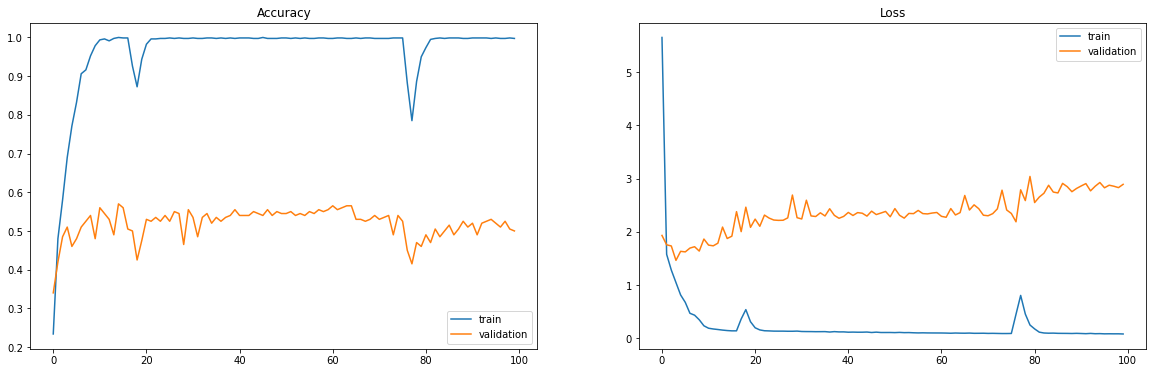

In [128]:
model_plot_validation(history6)

In [129]:
print("Training Accuracy model 6: ", model_6.evaluate(x_train, y_train, verbose=0)[1])
print("Training Loss model 6: ", model_6.evaluate(x_train, y_train, verbose=0)[0])

print("Testing Accuracy model 6: ", model_6.evaluate(x_test, y_test, verbose=0)[1])
print("Testing Loss model 6: ", model_6.evaluate(x_test, y_test, verbose=0)[0])

Training Accuracy model 6:  0.9987499713897705
Training Loss model 6:  0.08325640857219696
Testing Accuracy model 6:  0.5
Testing Loss model 6:  2.893501043319702


With L2 we have increase a bit the test accuracy comparing with the first CNN model. But this is worst than the model with a 0.5 dropout.

###### L1 

In [130]:
model_7 = Sequential()
model_7.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu', kernel_regularizer=l1(0.01)))
model_7.add(MaxPooling2D(pool_size=2))

model_7.add(Conv2D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=l1(0.01)))
model_7.add(MaxPooling2D(pool_size=2))

model_7.add(Conv2D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l1(0.01)))
model_7.add(MaxPooling2D(pool_size=2))

model_7.add(Conv2D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l1(0.01)))
model_7.add(MaxPooling2D(pool_size=2))

model_7.add(Flatten())
model_7.add(Dense(num_labels, activation='softmax')) 

In [131]:
model_7.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [132]:
history7 = fit_model(model_7, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, file_name='conv7.hdf5')

Epoch 1/100
25/25 [==============================] - 33s 1s/step - loss: 28.9729 - accuracy: 0.1649 - val_loss: 19.7365 - val_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 19.73648, saving model to saved_models\conv7.hdf5
Epoch 2/100
25/25 [==============================] - 30s 1s/step - loss: 18.6293 - accuracy: 0.3852 - val_loss: 16.0871 - val_accuracy: 0.3400

Epoch 00002: val_loss improved from 19.73648 to 16.08709, saving model to saved_models\conv7.hdf5
Epoch 3/100
25/25 [==============================] - 30s 1s/step - loss: 15.0560 - accuracy: 0.5357 - val_loss: 13.5093 - val_accuracy: 0.4150

Epoch 00003: val_loss improved from 16.08709 to 13.50933, saving model to saved_models\conv7.hdf5
Epoch 4/100
25/25 [==============================] - 30s 1s/step - loss: 12.6461 - accuracy: 0.5624 - val_loss: 11.5725 - val_accuracy: 0.4500

Epoch 00004: val_loss improved from 13.50933 to 11.57254, saving model to saved_models\conv7.hdf5
Epoch 5/100
25/25 [==================

25/25 [==============================] - 30s 1s/step - loss: 1.2910 - accuracy: 0.9805 - val_loss: 3.0674 - val_accuracy: 0.4950

Epoch 00036: val_loss improved from 3.10237 to 3.06741, saving model to saved_models\conv7.hdf5
Epoch 37/100
25/25 [==============================] - 30s 1s/step - loss: 1.1799 - accuracy: 0.9997 - val_loss: 3.0120 - val_accuracy: 0.5050

Epoch 00037: val_loss improved from 3.06741 to 3.01205, saving model to saved_models\conv7.hdf5
Epoch 38/100
25/25 [==============================] - 30s 1s/step - loss: 1.1118 - accuracy: 0.9982 - val_loss: 3.0783 - val_accuracy: 0.5400

Epoch 00038: val_loss did not improve from 3.01205
Epoch 39/100
25/25 [==============================] - 30s 1s/step - loss: 1.0681 - accuracy: 0.9986 - val_loss: 2.9286 - val_accuracy: 0.4900

Epoch 00039: val_loss improved from 3.01205 to 2.92865, saving model to saved_models\conv7.hdf5
Epoch 40/100
25/25 [==============================] - 31s 1s/step - loss: 1.0365 - accuracy: 0.9972 - 


Epoch 00076: val_loss did not improve from 2.68174
Epoch 77/100
25/25 [==============================] - 30s 1s/step - loss: 0.5507 - accuracy: 0.9996 - val_loss: 2.8299 - val_accuracy: 0.4550

Epoch 00077: val_loss did not improve from 2.68174
Epoch 78/100
25/25 [==============================] - 30s 1s/step - loss: 0.5374 - accuracy: 0.9995 - val_loss: 2.7495 - val_accuracy: 0.4850

Epoch 00078: val_loss did not improve from 2.68174
Epoch 79/100
25/25 [==============================] - 30s 1s/step - loss: 0.5310 - accuracy: 0.9944 - val_loss: 2.7745 - val_accuracy: 0.4950

Epoch 00079: val_loss did not improve from 2.68174
Epoch 80/100
25/25 [==============================] - 31s 1s/step - loss: 0.5170 - accuracy: 0.9987 - val_loss: 2.8561 - val_accuracy: 0.4500

Epoch 00080: val_loss did not improve from 2.68174
Epoch 81/100
25/25 [==============================] - 31s 1s/step - loss: 0.5143 - accuracy: 0.9986 - val_loss: 2.7980 - val_accuracy: 0.4700

Epoch 00081: val_loss did not

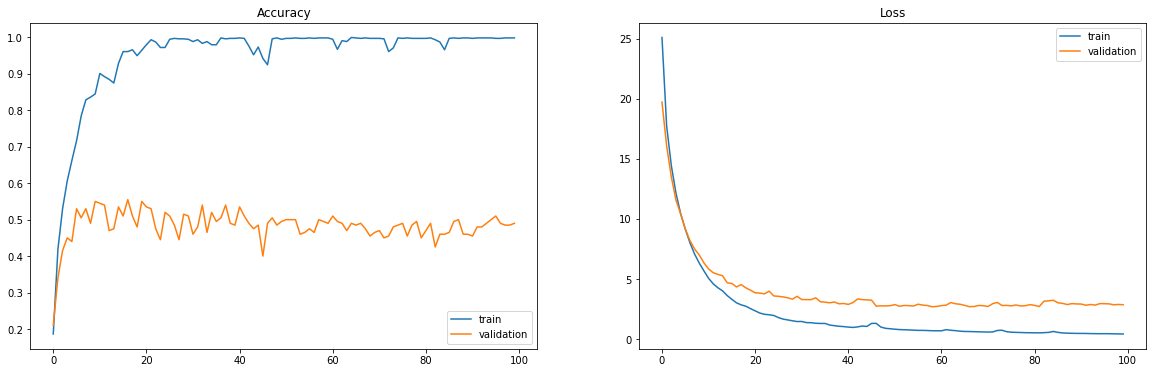

In [133]:
model_plot_validation(history7)

In [134]:
print("Training Accuracy model 7: ", model_7.evaluate(x_train, y_train, verbose=0)[1])
print("Training Loss model 7: ", model_7.evaluate(x_train, y_train, verbose=0)[0])

print("Testing Accuracy model 7: ", model_7.evaluate(x_test, y_test, verbose=0)[1])
print("Testing Loss model 7: ", model_7.evaluate(x_test, y_test, verbose=0)[0])

Training Accuracy model 7:  0.9987499713897705
Training Loss model 7:  0.41430968046188354
Testing Accuracy model 7:  0.49000000953674316
Testing Loss model 7:  2.850834369659424


No improvements.

##### Data Augmentation

As we did for the MLP model, we can apply data augmention so let's do the same steps:

Calculate TRAIN features:

In [37]:
features = []
for genre in GENRES:
    for i in range(100):
        file_name = os.path.join(os.path.abspath(data_train_location), genre + '/', genre + '.' + str(i).rjust(5, '0') + '.au')
        d = get_augmented_data(file_name)
        if d is not None:
            for augmented_audio in d[0]:
                data = extract_features_from_audio(augmented_audio, d[1])
                features.append([data, genre])

features_aug_df = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(features_aug_df), ' files') 

C:\Users\Elvira\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\blues/blues.00013.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\blues/blues.00013.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\blues/blues.00021.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\blues/blues.00021.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\blues/blues.00026.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\blues/blues.00026.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\classical/classical.00049.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\classical/classical.00049.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\classical/classical.00050.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\classical/classical.00050.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\classical/classical.00051.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\classical/cl

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\country/country.00073.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\country/country.00073.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\country/country.00074.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\country/country.00074.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\country/country.00079.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\country/country.00079.au
[Errno 

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\disco/disco.00090.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\disco/disco.00090.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\disco/disco.00093.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\disco/disco.00093.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\disco/disco.00096.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\disco/disco.00096.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\jazz/jazz.00039.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\jazz/jazz.00039.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\jazz/jazz.00042.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\jazz/jazz.00042.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\jazz/jazz.00046.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\jazz/jazz.00046.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\metal/metal.00054.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\metal/metal.00054.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\metal/metal.00068.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\metal/metal.00068.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\metal/metal.00073.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\metal/metal.00073.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\pop/pop.00084.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\pop/pop.00084.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\pop/pop.00088.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\pop/pop.00088.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\pop/pop.00090.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\pop/pop.00090.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\rock/rock.00021.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\rock/rock.00021.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\rock/rock.00026.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\rock/rock.00026.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\rock/rock.00039.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\rock/rock.00039.au
[Errno 2] No such file or directory: 'C:\\U

Calculate TEST features:

In [38]:
features = []
for genre in GENRES:
    for i in range(100):
        file_name = os.path.join(os.path.abspath(data_test_location), genre + '/', genre + '.' + str(i).rjust(5, '0') + '.au')
        data = extract_features(file_name)
        if data is not None:
            features.append([data, genre])

features_test_df = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(features_test_df), ' files') 

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00000.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00000.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00001.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00001.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00002.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00002.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00038.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00038.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00040.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00040.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00041.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00041.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00075.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00075.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00076.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00076.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\blues/blues.00077.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00077.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00014.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00014.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00015.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00015.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00016.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.0001

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00044.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00044.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00045.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00045.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00047.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.0004

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00080.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00080.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00082.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00082.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\classical/classical.00083.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.0008

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\country/country.00014.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00014.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\country/country.00015.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00015.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\country/country.00016.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00016.au
[Errno 2] No such f

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\country/country.00082.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00082.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\country/country.00083.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00083.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\country/country.00085.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00085.au
[Errno 2] No such f

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00017.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00017.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00018.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00018.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00019.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00019.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00052.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00052.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00053.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00053.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00055.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00055.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00085.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00085.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00086.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00086.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\disco/disco.00087.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00087.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00017.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00017.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00018.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00018.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00019.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00019.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00052.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00052.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00053.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00053.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00055.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00055.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00085.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00085.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00086.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00086.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\hiphop/hiphop.00087.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00087.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00016.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00016.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00017.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00017.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00018.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00018.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00052.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00052.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00053.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00053.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00055.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00055.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00091.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00091.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00092.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00092.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\jazz/jazz.00094.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00094.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00022.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00022.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00023.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00023.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00024.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00024.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00057.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00057.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00058.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00058.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00059.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00059.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00091.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00091.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00092.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00092.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\metal/metal.00094.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00094.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00022.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00022.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00023.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00023.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00024.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00024.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00058.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00058.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00059.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00059.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00060.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00060.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00094.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00094.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00095.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00095.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\pop/pop.00097.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00097.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\reggae/reggae.00027.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00027.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\reggae/reggae.00028.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00028.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\reggae/reggae.00029.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00029.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\reggae/reggae.00069.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00069.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\reggae/reggae.00070.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00070.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\reggae/reggae.00071.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00071.au
[Errno 2] No such file or direc

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00009.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\rock/rock.00010.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00010.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\rock/rock.00011.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00011.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\rock/rock.00012.au'
Error encountered while parsing file:  C:\Users\Elvira\

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\rock/rock.00075.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00075.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\rock/rock.00076.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00076.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\val\\rock/rock.00077.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00077.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira

In [39]:
# Convert features and corresponding classification labels into numpy arrays
x_train_aug = np.array(features_aug_df.feature.tolist())
x_test_aug = np.array(features_test_df.feature.tolist())
y_aug = np.array(features_aug_df.class_label.tolist())
y_test_aug = np.array(features_test_df.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
y_train_aug = to_categorical(le.fit_transform(y_aug))
y_test_aug = to_categorical(le.fit_transform(y_test_aug)) 

Check data dimensions:

In [40]:
len(x_train_aug[0]), len(x_train_aug[0][0]), x_train_aug.shape

(40, 1320, (3200, 40, 1320))

In [41]:
len(x_test_aug[0]), len(x_test_aug[0][0]), x_test_aug.shape

(40, 1320, (200, 40, 1320))

In [42]:
x_train_aug = x_train_aug.reshape(x_train_aug.shape[0], num_rows, num_columns, num_channels)
x_test_aug = x_test_aug.reshape(x_test_aug.shape[0], num_rows, num_columns, num_channels)

Let's take the first created model and train this with the augmented data:

In [46]:
model_8 = model1(num_rows, num_columns, num_channels, 'relu', kernel_size = 2, pool_size = 2, dropout= 0.2)

In [47]:
model_8.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [48]:
history8 = fit_model(model_8, x_train_aug, y_train_aug, x_test_aug, y_test_aug,
                     epochs=100, batch_size=32, file_name='conv8.hdf5')

Epoch 1/100
100/100 [==============================] - 151s 1s/step - loss: 16.5702 - accuracy: 0.1283 - val_loss: 2.1534 - val_accuracy: 0.2550

Epoch 00001: val_loss improved from inf to 2.15344, saving model to saved_models\conv8.hdf5
Epoch 2/100
100/100 [==============================] - 136s 1s/step - loss: 2.0545 - accuracy: 0.2583 - val_loss: 1.7719 - val_accuracy: 0.3300

Epoch 00002: val_loss improved from 2.15344 to 1.77187, saving model to saved_models\conv8.hdf5
Epoch 3/100
100/100 [==============================] - 135s 1s/step - loss: 1.7244 - accuracy: 0.3904 - val_loss: 1.7326 - val_accuracy: 0.3550

Epoch 00003: val_loss improved from 1.77187 to 1.73260, saving model to saved_models\conv8.hdf5
Epoch 4/100
100/100 [==============================] - 135s 1s/step - loss: 1.5691 - accuracy: 0.4319 - val_loss: 1.6110 - val_accuracy: 0.4050

Epoch 00004: val_loss improved from 1.73260 to 1.61102, saving model to saved_models\conv8.hdf5
Epoch 5/100
100/100 [==================

100/100 [==============================] - 134s 1s/step - loss: 0.1283 - accuracy: 0.9586 - val_loss: 2.2740 - val_accuracy: 0.6250

Epoch 00041: val_loss did not improve from 1.48010
Epoch 42/100
100/100 [==============================] - 133s 1s/step - loss: 0.1334 - accuracy: 0.9569 - val_loss: 2.2709 - val_accuracy: 0.6550

Epoch 00042: val_loss did not improve from 1.48010
Epoch 43/100
100/100 [==============================] - 134s 1s/step - loss: 0.1157 - accuracy: 0.9624 - val_loss: 2.5530 - val_accuracy: 0.6500

Epoch 00043: val_loss did not improve from 1.48010
Epoch 44/100
100/100 [==============================] - 133s 1s/step - loss: 0.1070 - accuracy: 0.9660 - val_loss: 2.4907 - val_accuracy: 0.5750

Epoch 00044: val_loss did not improve from 1.48010
Epoch 45/100
100/100 [==============================] - 143s 1s/step - loss: 0.1054 - accuracy: 0.9718 - val_loss: 2.4309 - val_accuracy: 0.6150

Epoch 00045: val_loss did not improve from 1.48010
Epoch 46/100
100/100 [======


Epoch 00082: val_loss did not improve from 1.48010
Epoch 83/100
100/100 [==============================] - 149s 1s/step - loss: 0.0375 - accuracy: 0.9847 - val_loss: 2.6978 - val_accuracy: 0.6350

Epoch 00083: val_loss did not improve from 1.48010
Epoch 84/100
100/100 [==============================] - 138s 1s/step - loss: 0.0904 - accuracy: 0.9721 - val_loss: 3.1345 - val_accuracy: 0.6200

Epoch 00084: val_loss did not improve from 1.48010
Epoch 85/100
100/100 [==============================] - 136s 1s/step - loss: 0.1072 - accuracy: 0.9701 - val_loss: 2.9384 - val_accuracy: 0.6000

Epoch 00085: val_loss did not improve from 1.48010
Epoch 86/100
100/100 [==============================] - 138s 1s/step - loss: 0.0713 - accuracy: 0.9798 - val_loss: 2.8305 - val_accuracy: 0.6450

Epoch 00086: val_loss did not improve from 1.48010
Epoch 87/100
100/100 [==============================] - 135s 1s/step - loss: 0.0717 - accuracy: 0.9773 - val_loss: 3.0464 - val_accuracy: 0.6100

Epoch 00087: v

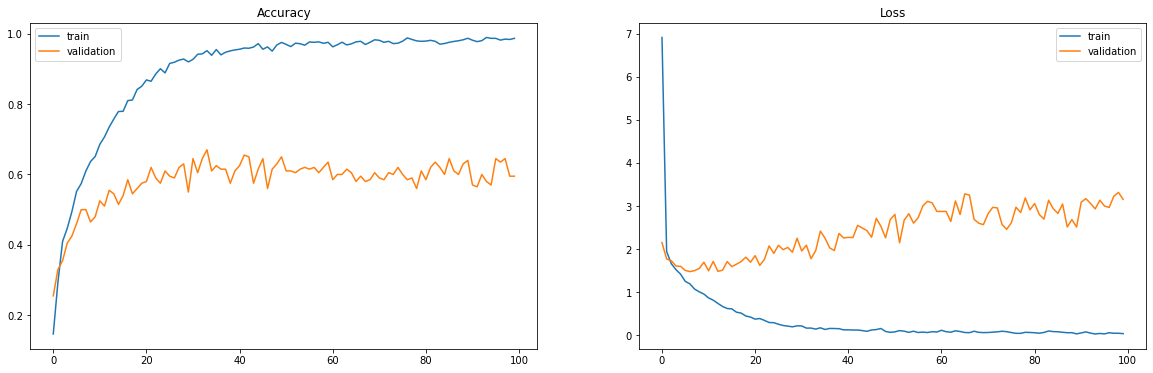

In [49]:
model_plot_validation(history8)

In [50]:
score = model_8.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_8.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Training Loss: ", score[0])

Training Accuracy:  0.9990624785423279
Training Loss:  0.003957642242312431
Testing Accuracy:  0.5950000286102295
Training Loss:  3.155275344848633


By using data augmentation we have been able to increase test accuracy a 10 % more.
- First model: 49%
- First model + data augmentation: 59%

Now, let's check what happens with the model which seems better than the first CNN model. A model with 0.5 dropout.

In [137]:
model_8_1= model1(num_rows, num_columns, num_channels, 'relu', kernel_size = 2, pool_size = 2, dropout= 0.5)
model_8_1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [138]:
history8_1 = fit_model(model_8_1, x_train_aug, y_train_aug, x_test_aug, y_test_aug,
                     epochs=200, batch_size=32, file_name='conv81.hdf5')

Epoch 1/200
100/100 [==============================] - 169s 1s/step - loss: 26.1159 - accuracy: 0.1267 - val_loss: 2.3025 - val_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 2.30246, saving model to saved_models\conv81.hdf5
Epoch 2/200
100/100 [==============================] - 149s 1s/step - loss: 2.5741 - accuracy: 0.1102 - val_loss: 2.3027 - val_accuracy: 0.1050

Epoch 00002: val_loss did not improve from 2.30246
Epoch 3/200
100/100 [==============================] - 140s 1s/step - loss: 2.3756 - accuracy: 0.1110 - val_loss: 2.3029 - val_accuracy: 0.1000

Epoch 00003: val_loss did not improve from 2.30246
Epoch 4/200
100/100 [==============================] - 139s 1s/step - loss: 2.3182 - accuracy: 0.1270 - val_loss: 2.2988 - val_accuracy: 0.1100

Epoch 00004: val_loss improved from 2.30246 to 2.29877, saving model to saved_models\conv81.hdf5
Epoch 5/200
100/100 [==============================] - 141s 1s/step - loss: 2.2708 - accuracy: 0.1234 - val_loss: 2.2036 - val_


Epoch 00038: val_loss did not improve from 1.57264
Epoch 39/200
100/100 [==============================] - 137s 1s/step - loss: 0.9780 - accuracy: 0.6445 - val_loss: 1.6848 - val_accuracy: 0.4200

Epoch 00039: val_loss did not improve from 1.57264
Epoch 40/200
100/100 [==============================] - 137s 1s/step - loss: 0.9478 - accuracy: 0.6586 - val_loss: 1.7191 - val_accuracy: 0.3850

Epoch 00040: val_loss did not improve from 1.57264
Epoch 41/200
100/100 [==============================] - 137s 1s/step - loss: 0.9331 - accuracy: 0.6660 - val_loss: 1.7649 - val_accuracy: 0.3450

Epoch 00041: val_loss did not improve from 1.57264
Epoch 42/200
100/100 [==============================] - 144s 1s/step - loss: 0.9304 - accuracy: 0.6585 - val_loss: 1.7434 - val_accuracy: 0.4000

Epoch 00042: val_loss did not improve from 1.57264
Epoch 43/200
100/100 [==============================] - 148s 1s/step - loss: 0.9220 - accuracy: 0.6564 - val_loss: 1.6740 - val_accuracy: 0.3900

Epoch 00043: v


Epoch 00121: val_loss did not improve from 1.57264
Epoch 122/200
100/100 [==============================] - 136s 1s/step - loss: 0.2358 - accuracy: 0.9235 - val_loss: 2.8224 - val_accuracy: 0.4350

Epoch 00122: val_loss did not improve from 1.57264
Epoch 123/200
100/100 [==============================] - 138s 1s/step - loss: 0.2462 - accuracy: 0.9133 - val_loss: 3.4447 - val_accuracy: 0.4000

Epoch 00123: val_loss did not improve from 1.57264
Epoch 124/200
100/100 [==============================] - 137s 1s/step - loss: 0.2363 - accuracy: 0.9151 - val_loss: 3.4834 - val_accuracy: 0.3850

Epoch 00124: val_loss did not improve from 1.57264
Epoch 125/200
100/100 [==============================] - 136s 1s/step - loss: 0.2373 - accuracy: 0.9145 - val_loss: 3.3634 - val_accuracy: 0.3600

Epoch 00125: val_loss did not improve from 1.57264
Epoch 126/200
100/100 [==============================] - 136s 1s/step - loss: 0.2054 - accuracy: 0.9314 - val_loss: 2.8840 - val_accuracy: 0.4350

Epoch 001

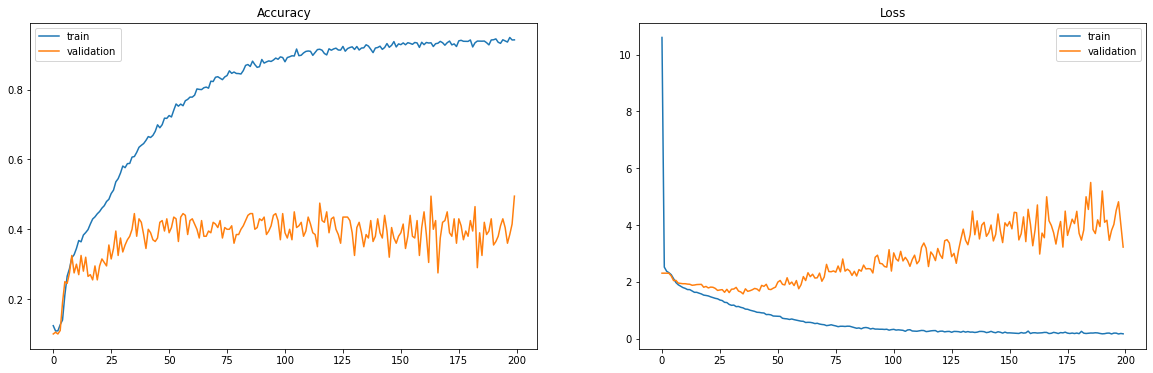

In [139]:
model_plot_validation(history8_1)

In [140]:
score = model_8_1.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_8_1.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Training Loss: ", score[0])

Training Accuracy:  0.7300000190734863
Training Loss:  0.8053216338157654
Testing Accuracy:  0.4950000047683716
Training Loss:  3.2210090160369873


It seems as if the model with dropout 0.5 wasn't good enough. The data augmentation didn't give good results.

# CNN + RNN Model

Finally we will create a model combining CNN and RNN


This new model consists of five layers:
1. input layer (convulation + max pooling): 32 units, Relu activation function and 0.2% of dropout.
2. convulation + max pooling layer: 64 units, Relu activation function and 0.2% of dropout. 
3. convulation + max pooling layer: 128 units, Relu activation function and 0.2% of dropout. 
4. LSTM layer: 512 units and 0.2% of dropout.
5. output layer 

This time we have change the kernel size from 2 to 3.

In [101]:
model_9 = Sequential()
model_9.add(Conv2D(filters=32, kernel_size=3, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_9.add(MaxPooling2D(pool_size=2))
model_9.add(Dropout(0.2))

model_9.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_9.add(MaxPooling2D(pool_size=4))
model_9.add(Dropout(0.2))

model_9.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model_9.add(MaxPooling2D(pool_size=2))
model_9.add(Dropout(0.2))

model_9.add(Reshape((81, 128)))
model_9.add(LSTM(512, return_sequences=True))
model_9.add(Dropout(0.2))

model_9.add(Flatten())
model_9.add(Dense(num_labels, activation='softmax')) 

In [102]:
model_9.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 38, 1318, 32)      320       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 19, 659, 32)       0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 19, 659, 32)       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 17, 657, 64)       18496     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 4, 164, 64)        0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 4, 164, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 2, 162, 128)     

In [103]:
model_9.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [104]:
history = fit_model(model_9, x_train_aug, y_train_aug, x_test_aug, y_test_aug,
                     epochs=60, batch_size=32, file_name='convlstm.hdf5')

Epoch 1/60
100/100 [==============================] - 368s 3s/step - loss: 3.1476 - accuracy: 0.1780 - val_loss: 1.9335 - val_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 1.93352, saving model to saved_models\convlstm.hdf5
Epoch 2/60
100/100 [==============================] - 329s 3s/step - loss: 1.7592 - accuracy: 0.3556 - val_loss: 1.5324 - val_accuracy: 0.4450

Epoch 00002: val_loss improved from 1.93352 to 1.53242, saving model to saved_models\convlstm.hdf5
Epoch 3/60
100/100 [==============================] - 368s 4s/step - loss: 1.5186 - accuracy: 0.4501 - val_loss: 1.5492 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 1.53242
Epoch 4/60
100/100 [==============================] - 380s 4s/step - loss: 1.2061 - accuracy: 0.5598 - val_loss: 1.3705 - val_accuracy: 0.5700

Epoch 00004: val_loss improved from 1.53242 to 1.37055, saving model to saved_models\convlstm.hdf5
Epoch 5/60
100/100 [==============================] - 340s 3s/step - loss: 1.007


Epoch 00041: val_loss did not improve from 1.14480
Epoch 42/60
100/100 [==============================] - 320s 3s/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 2.3807 - val_accuracy: 0.6500

Epoch 00042: val_loss did not improve from 1.14480
Epoch 43/60
100/100 [==============================] - 321s 3s/step - loss: 0.0253 - accuracy: 0.9935 - val_loss: 2.4463 - val_accuracy: 0.6250

Epoch 00043: val_loss did not improve from 1.14480
Epoch 44/60
100/100 [==============================] - 342s 3s/step - loss: 0.0624 - accuracy: 0.9741 - val_loss: 2.6045 - val_accuracy: 0.6400

Epoch 00044: val_loss did not improve from 1.14480
Epoch 45/60
100/100 [==============================] - 322s 3s/step - loss: 0.0978 - accuracy: 0.9655 - val_loss: 2.5849 - val_accuracy: 0.6600

Epoch 00045: val_loss did not improve from 1.14480
Epoch 46/60
100/100 [==============================] - 350s 4s/step - loss: 0.1412 - accuracy: 0.9577 - val_loss: 3.0181 - val_accuracy: 0.6750

Epoch 00046: val_lo

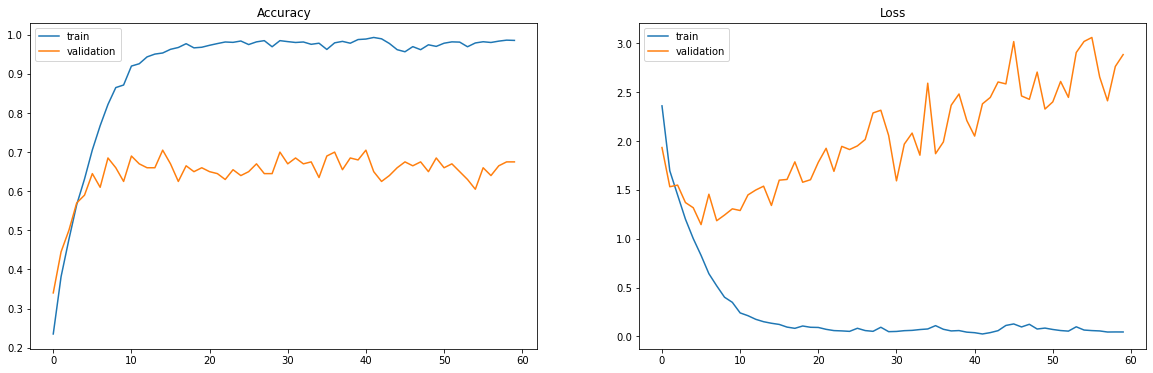

In [105]:
model_plot_validation(history)

In [106]:
score = model_9.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_9.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Test Loss: ", score[0])

Training Accuracy:  0.9987499713897705
Training Loss:  0.004736253060400486
Testing Accuracy:  0.675000011920929
Test Loss:  2.884805202484131


This new model seems to have given a good result. Now the tes accuracy has increased until 67% when our first CNN model had 49%. Also the Loss is lower.